### Learning prior iteratively

In [1]:
# setup the environment
import nengo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
% matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

import seaborn as sns
sns.set_context("talk")

In [2]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# our function domain is thetas (i.e., age from 1 to 120)
# Remember thetas is same as Z in our plate notation (shown later)
# We are also assuming discrete values for age, because people 
# usually report integers for age when asked to predict.
thetas = np.linspace(start=1, stop=max_age, num=max_age)

# compute likelihood 
def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# computer prior
def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 

# computer posterior
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post

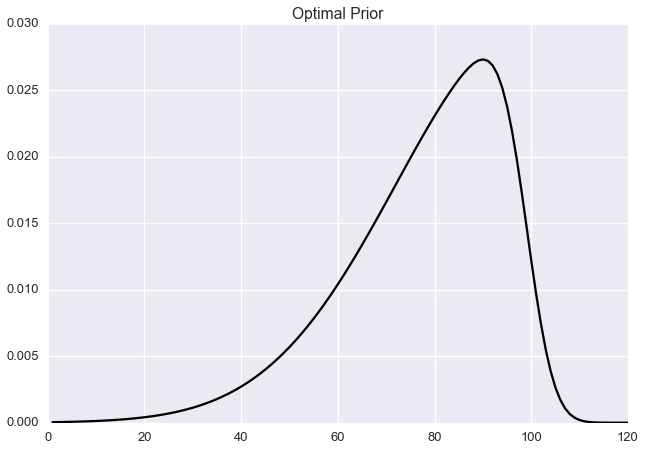

In [3]:
# Prior which is the actual solution and
# is used to generate the observed data 

# prior parameters
#skew = -4    # fixed parameter
#loc = 95     # to be estimated
#scale = 26   # fixed parameter

skew = -6    # fixed parameter
loc = 99    # to be estimated
scale = 27   # fixed parameter


prior = skew_gauss(skew, loc, scale)
plt.figure()
plt.title("Optimal Prior")
plt.plot(thetas, prior, 'k')


mean = st.skewnorm.mean(skew, loc, scale)
std_dev = st.skewnorm.std(skew, loc, scale)
#print "Mean: ", mean
#print "Std. deviation: ", std_dev

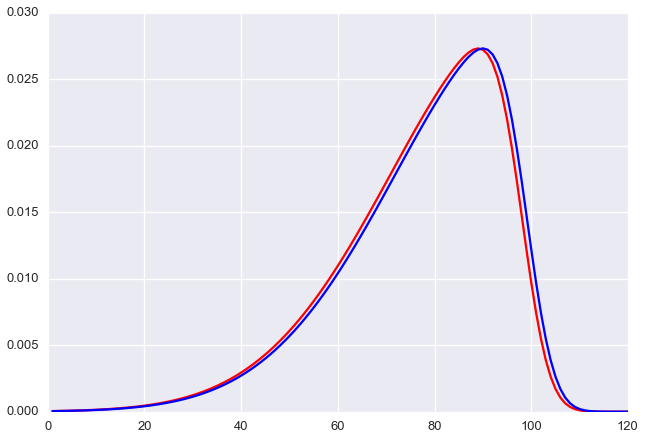

In [4]:
# Showing that the difference between priors with 
# loc = 95 and 96 is not too much and hence the fractional 
# values between any two integer values of loc can be ignored
# to limit the search space and simplify the problem.
plt.figure()
prior = skew_gauss(skew, 98, 27)
plt.plot(thetas, prior, 'r')
prior = skew_gauss(skew, 99, 27)
plt.plot(thetas, prior, 'b')

Mean:  -0.249769032776
Std. deviation:  16.6567498647
Mean:  120.750230967
Std. deviation:  16.6567498647


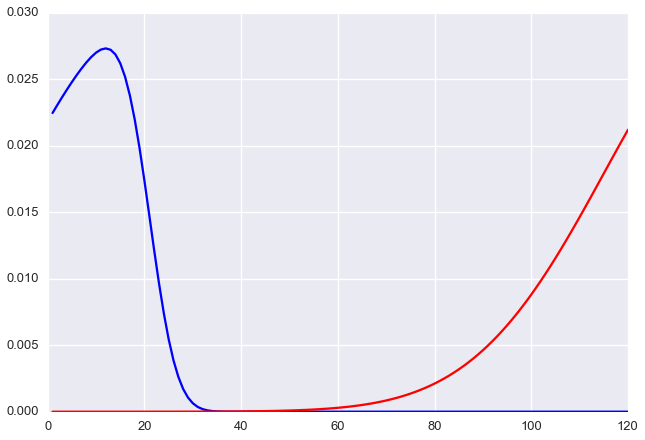

In [5]:
# The Prior is conditioned on three parameters, however
# we assume that two of the parameters are fixed and estimate
# only one parameter 'loc'. Thus the hyperparameter alpha to  
# be is estimated is 'loc' in this case.

# Check the range of values we should be searching over.
# We know that the mean age should be between 0 to 120 since 
# we are assuming max age is 120. Hence, we should search over
# the range of values of 'loc' that give mean between 0 to 120.

# lower bound
loc_r = 21 

prior = skew_gauss(skew, loc_r, scale)
plt.figure()
plt.plot(thetas, prior, 'b')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# upper bound
loc_r = 142 

prior = skew_gauss(skew, loc_r, scale)
plt.plot(thetas, prior, 'r')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# Thus the search range for 'loc' is 20 to 141 since priors
# beyond these values wouldn't make sense for this problem
# The hypothesis is that people are able to constrain their
# search space based on the knowledge of min and max ages
# they observe in the world around them.

# Thus loc has discrete values from 20 - 141. 
# Remember alpha = loc 
upper = 142 
lower = 21
alpha = np.arange(lower, upper+1, 1)   # possible values of alpha
#M = upper-lower+1  # number of discrete possibilities of alpha

The two stage hierarchical bayes model is summarised in the <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In [6]:
# These two functions are used to generate the sample X. 

# Function to sample discrete random values from a skewed gaussian distribution
def randn_skew(n_samples, skew=0.0, loc=0.0, scale=1.0):
    probs = skew_gauss(skew, loc, scale)
    probs /= sum(probs)   # to make sure the sum is exactly 1 and not 0.999
    samples = np.random.choice(thetas, size=n_samples, replace=True, p=probs)   
    samples = list(samples)  #convert ndarray to a python list
    return samples

# Function to draw samples X for the given number of trials
def draw(n_trials, n_samples):
    x_vector = []
    for i in np.arange(n_trials):
        z_vector = randn_skew(n_samples=n_samples, skew=skew, loc=loc, scale=scale)  # generating Z from alpha
        x_vector.append(np.asarray([np.random.randint(low=1, high=th+1) for th in z_vector]))   # X from Z
    return x_vector

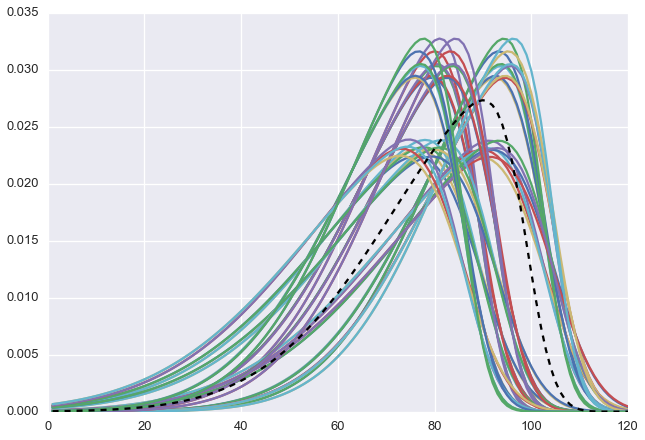

In [39]:
# Start here for basal ganglia
# rmse pretty low 0.0007 upto 0.04 with 15, 15, 3 samples
# rmse similar with 10, 10, 3 samples as well. 
alpha = np.random.uniform(82, 109, 5)    #loc or shift
alpha2 = np.random.uniform(20, 37, 5)    #scale 
alpha3 = np.random.uniform(-8, -4, 2)     #skew

#alpha = np.random.uniform(89, 109, 10)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 3)     #skew

M = len(alpha)*len(alpha2)*len(alpha3)
plt.figure()

prior = np.zeros((M, max_age))
l = 0
for i in alpha:
    for j in alpha2:
        for k in alpha3:
            prior[l, :] =  skew_gauss(k, i, j)    # p(Z)
            prior[l, :] = prior[l, :]/sum(prior[l, :])  # normalize prior 
            if l!=100:
                plt.plot(thetas, prior[l, :])
            l = l+1
    
np.random.shuffle(prior)
    
#manually add the optimal prior
pred_index = 3
prior[pred_index,:] = skew_gauss(-6, 99, 27) 
prior[pred_index, :] = prior[pred_index, :]/sum(prior[pred_index, :])
plt.plot(thetas, prior[pred_index, :], 'k--')

# priors conditioned on alpha: p(Z/A)    
pZA = prior
logpZA = np.log(pZA)    

50


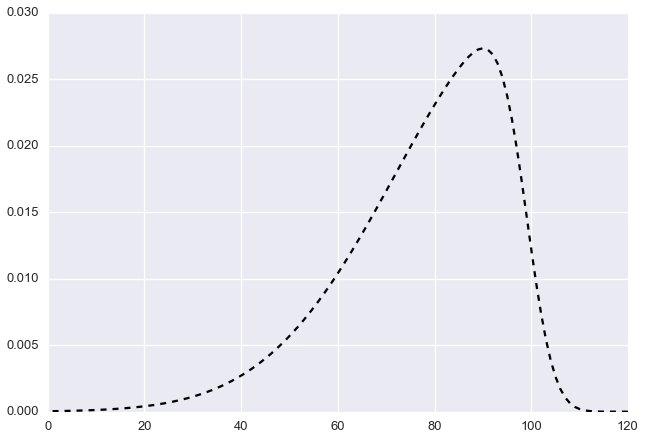

In [40]:
print M
#plt.plot(thetas, prior[570, :], 'r--')
plt.plot(thetas, prior[pred_index, :], 'k--')

In [41]:
from nengo.utils.progress import ProgressTracker

# Function to compute the likelihood of each  
# 'x' in the Sample X (x_vector)
def compute_lik(x_vector):
    lik = np.zeros((len(x_vector), max_age))
    i = 0
    count = 0
    for obs in x_vector:
        if int(obs) > 120:
            obs = 120   
            count = count + 1 
        lik[i,:] = likelihood(obs)    #pXZ
        i = i+1
    #print "Count samples above 120: ", count    
    return lik    

    
estimate_list = []
# Online EM where the stored terms are decayed away
# Adding iterations for each example (1) similar to STM cycling
# around hippocampus while being consolidated in the LTM.
# 1) Inner terations: As each example comes in, we update the stored 
# terms and  iterate 'num_inner_iter' times for each individual example.
# 2) Outer Iterations: After all examples have been received, we repeat the 
# entire process/iterate by reusing the same set of examples 'num_iter' times.
# This might be similar to refelcting on past experiences etc.
def stepwise_em_iterative(x, num_iter=1, num_inner_iter=20): #num_iter=8
    _pXZ = compute_lik(x)
    a =  np.random.randint(0, M) 
    #print "start: ", a           
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far
    beta = 0.65        # 1 gave 40% and 0.5 gave 98% accuracy
    _pXZ_list = list(enumerate(_pXZ))

    iterations = 0
    current_guess = -1
    guess_counter = 0
    
    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            for _ in range(num_inner_iter): 
                L = np.zeros(M)   
                pxz = p * pZA[a, :]
                L += (pxz / np.sum(pxz)).dot(logpZA.T/10.0)
                #print np.pxz
                
                gamma = np.power(float(k+2), -beta)  
                k = k + 1

                S = gamma*L + (1-gamma)*S
                #print S + np.ones(M)
                max_a = a = np.argmax(S) 
                estimate_list.append(max_a)
                
                if current_guess == max_a:
                    guess_counter = guess_counter + 1
                else:
                    guess_counter = 0
                    
                #if guess_counter >= 20000:
                #    print "Total interations: ", iterations
                #    print "max_a in: ", max_a
                #   return max_a
                    
                
                current_guess = max_a
                iterations = iterations + 1
        
    print "\n TRIAL END"
    print "\n max_a: ", max_a   
    print "\n RMSE: ", rmse(pZA[a, :], pZA[pred_index, :])
    #print "Total interations out: ", iterations
    return max_a


'''
if L[max_a] > best_utility:
    best_a = max_a
    best_utility = L[max_a]

if prev_max == max_a:
    L[a] = np.min(L)
    a = np.argmax(L)
    if a == best_a:
        break 
prev_max = max
'''


# Accuracy defined based on +/2 withing the optimal value
def grade_solution(f, n_trials, n_samples, name=None, plot=True):
    X = draw(n_trials, n_samples)
    
    correct = 0
    diff = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            #print "X, alpha: ", X[j], alpha[j]
            a_est = f(X[j])
            if a_est == pred_index:
            #if a_est >= loc-2 and a_est <= loc+2: 
                correct += 1
            diff[j] = a_est-loc #np.abs(a_est-loc)
            progress.step()
    acc = correct / float(n_trials)
    #print ("%s (Accuracy = %.3f)" % (name, acc))
    
    if plot:
        plt.figure()
        plt.title("%s (Accuracy = %.3f)" % (name, acc), fontsize=18)
        plt.plot(diff, 'o')
        sns.set_style('darkgrid')
        plt.xlabel("number of trials", fontsize=18)
        plt.ylabel("Diff. between estimate and ideal alpha", fontsize=18)
        sns.despine(offset=10)
        plt.show()
    return acc


def rmse(predictions, targets):
    return  np.sqrt(((predictions - targets) ** 2).mean()) #/ predictions.mean() 

There are two ways of evaluating these different algorithms. One is accuracy i.e., number of times the algorithm converges to the optimal value which is 95. Second, how close the convergence values are to the optimal value. I think its reasonable if the algorithm converges to values close to the optimal value, since they will lead to priors which are close, and hence can lead to similar samples $X$.

In [ ]:
estimate_list = []
grade_solution(stepwise_em_iterative, n_trials=1, n_samples=20, name="Stepwise Iterative EM")

RMSE:  0.00554988640251
Mean:  0.00833333333333
93.8268979942 33.5715409404 -6.81559706045


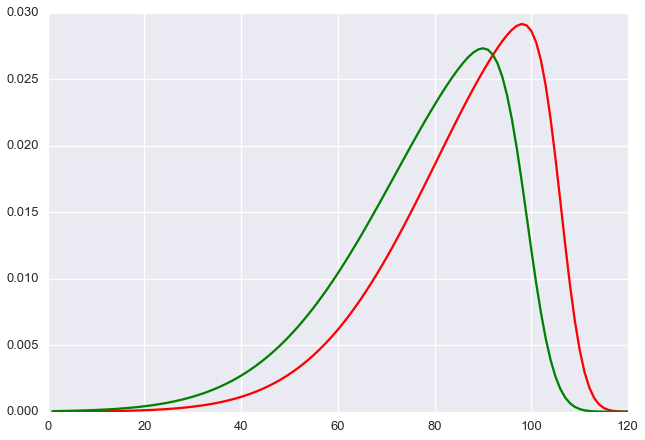

In [19]:
plt.figure()
plt.plot(thetas, pZA[147, :], 'r')
#plt.plot(thetas, pZA[21, :], 'r')
#plt.plot(thetas, pZA[88, :], 'r')
#plt.plot(thetas, pZA[45, :], 'r')
plt.plot(thetas, pZA[pred_index, :], 'g')

#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-5, -7, 2)

test = skew_gauss(-6, 21, 10) 
#mid = 60
test = test/sum(test)
#plt.plot(thetas, test, 'k')

print "RMSE: ", rmse(pZA[147, :], pZA[pred_index, :])

print "Mean: ", pZA[pred_index, :].mean()
print alpha[0], alpha2[0], alpha3[0]

In [ ]:
## NOTE: logpZA is negative
print (pxz / np.sum(pxz)).dot(logpZA.T/10.0)

In [ ]:
print logpZA.shape

### Nengo model

In [ ]:
# initial input
global p, i
i = 0
X = draw(1, 500)
_pXZ = compute_lik(X[0])
p = _pXZ[0]

a =  np.random.randint(0, M) 
L = np.zeros(M)   
pxz = p * pZA[a, :]   # pZA changing every one second, p (likelihood) changing every 20 secs or so. 
input = (pxz / np.sum(pxz))

model = nengo.Network(label='learn prior', seed=15)
#model.config[nengo.Ensemble].neuron_type=nengo.LIFRate() #nengo.Direct() #nengo.LIFRate() 
srch_space = M
global k
gate_input = 0
time = 0
k = 0
beta = 0.65
thal_factor = 0.8544 #0.653 #0.754 #0.684 #0.664 
global spy
global spy_pxz
with model:
    

    def ctx_drive(t, x):
        "t - current time in ms"
        "x - cortical state in cortex2 ensemble"
        global k, p, i, spy_pxz
        # every 5 iterations, a new sample comes in
        if t%20 == 0 and t!=0:
            i = i+1
            p = _pXZ[i]
        
        # this is when new prior is used to update ctx
        if t%1 == 0 and t!=0:
            k = k+1  # updating every 1 second, so each iteration is 1s
            nk = np.power(float(np.floor(k)+2), -beta)
            pxz = p * x   # p is the likelihood - later p should also vary after every 20 iterations or so
            #print "pxz: ", pxz
            #print "p: ", p
            #print "x: ", x 
            spy_pxz = [pxz, p, x]
            if pxz.any():
                pxz = pxz / np.sum(pxz)
            else:
                print "pxz = zero"
            return nk*pxz
        
        nk = np.power(float(np.floor(k)+2), -beta)
        if t<1:
            return nk*input 
        
        return nk*x
     
        
    def ctx_to_bg(x):
        # scale x such that all  
        # why does x sometimes have all equal elements??
        global spy
        if x.any():
            new_xmax = 1
            new_xmin = 0
            x_min = np.min(x)
            x_max = np.max(x)
            if x_min != x_max:
                spy = [x_min, x_max, x]
                x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin 
            else:
                print "all equal"
        return x    
    
    # cortincal input to the model
    cortex_in = nengo.Node(output=ctx_drive, size_out=max_age, size_in=max_age)
    cortex = nengo.Ensemble(neuron_type=nengo.Direct(), n_neurons=300, dimensions=max_age)
    nengo.Connection(cortex_in, cortex)
    
    cortex2 = nengo.Ensemble(neuron_type=nengo.Direct(), n_neurons=300, dimensions=max_age)
    
    # feedback to cortex after thalamus selects 
    # the optimal prior for a given iteration
    nengo.Connection(cortex2, cortex_in)


    # Creating the basal ganglia and the thalamus network
    BG = nengo.networks.BasalGanglia(dimensions=srch_space) 
    thal = nengo.networks.Thalamus(dimensions=srch_space)
    nengo.Connection(BG.output, thal.input, synapse=0.01)
    
    # This connection leads to n(k)*s(i)'
    # Defining the transforms for connecting the visual input to the BG
    # QQ: is the transform this or the weight matrix? Does it matter?
    # logpZA.T => (300, 120)
    #nengo.Connection(cortex, BG.input, transform=logpZA/10.0)
    node_ctx = nengo.Node(size_in=srch_space, size_out=srch_space)
    node_const = nengo.Node(output=np.ones(srch_space), size_out=srch_space)
    ensemble_ctx = nengo.Ensemble(n_neurons=100, dimensions=srch_space, neuron_type=nengo.Direct())
    nengo.Connection(cortex, node_ctx, transform=logpZA/10.0)
    nengo.Connection(node_const, node_ctx)
    nengo.Connection(node_ctx, ensemble_ctx)
    nengo.Connection(ensemble_ctx, BG.input, function=ctx_to_bg)

    
    
    # this function is no longer needed
    # These connection leads to (1-n(k))u
    # store bg output to memory (u = memory)
    def mem_to_bg(t, x):
        global k
        nk = np.power(float(np.floor(k)+2), -beta)
        return x * (1 - nk)   # this will be zero for the first 0.5 seconds since x is zero
      
    
    def gate_mem2(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "close the gate in first half, open in second"
        gate_input = 1
        comp = np.floor(t) if t>1 else 1
        if t%comp >= 0.5 and t%comp < 1:
            gate_input = 0
        elif t%comp >= 0 and t%comp < 0.5 and t!=0:
            gate_input = 1
        return gate_input  
    
    
    def gate_mem1(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "open the gate in first half, close in second"
        gate_input = 1
        comp = np.floor(t) if t>1 else 1
        if t%comp >= 0.5 and t%comp < 1:
            gate_input = 1
        elif t%comp >= 0 and t%comp < 0.5 and t!=0:
            gate_input = 0
        return gate_input
    
    
    # SS - I am also concerned that bg-thal might not be able to chose from so close values

    #'''
    # Memory circuit holding the weighted sum
    memory1 = nengo.networks.InputGatedMemory(n_neurons=300, dimensions=srch_space) 
    gate_in1 = nengo.Node(output=gate_mem1, size_out=1, size_in=1)
    nengo.Connection(gate_in1, memory1.gate)
    
    memory2 = nengo.networks.InputGatedMemory(n_neurons=300, dimensions=srch_space) 
    gate_in2 = nengo.Node(output=gate_mem2, size_out=1, size_in=1)
    nengo.Connection(gate_in2, memory2.gate)
    nengo.Connection(BG.input, memory1.input)
    nengo.Connection(memory1.output, memory2.input)
    
    node_mem = nengo.Node(output=mem_to_bg, size_in=srch_space, size_out=srch_space)
    nengo.Connection(memory2.output, node_mem)  #node is needed to multiply by updated (1-nk) over time
    nengo.Connection(node_mem, node_ctx)
    #'''

    # connect output of thalamus
    # pZA.T => (120, 300)
    nengo.Connection(thal.output, cortex2, transform=pZA.T/thal_factor)  
    
    # probes
    cortex_p = nengo.Probe(cortex, synapse=0.03)
    cortex2_p = nengo.Probe(cortex2, synapse=0.03)
    thal_p = nengo.Probe(thal.output, synapse=0.03)
    bg_p = nengo.Probe(BG.output, synapse=0.03)
    bg_pin = nengo.Probe(BG.input, synapse=0.03)
    
    #'''
    memory1_ip = nengo.Probe(memory1.input, synapse=0.03)
    memory1_op = nengo.Probe(memory1.output, synapse=0.03)
    memory1_gp = nengo.Probe(memory1.gate, synapse=0.03)
    memory2_ip = nengo.Probe(memory2.input, synapse=0.03)
    memory2_op = nengo.Probe(memory2.output, synapse=0.03)
    memory2_gp = nengo.Probe(memory2.gate, synapse=0.03)
    #'''
    
    node_memp = nengo.Probe(node_mem, synapse=0.03)
    node_ctxp = nengo.Probe(node_ctx, synapse=0.03)

    
sim = nengo.Simulator(model)  # Create the simulator
sim.run(60)                  # Run it for 1 second    

In [23]:
print spy_pxz

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [17]:
print spy[0]
print spy[1]
print spy[2]

0.99282568342
1.82211695501
[ 1.66336373  1.55468492  1.80602552  1.43800399  1.7873731   1.702476
  1.5904616   1.80998355  1.52315535  1.60880413  1.62548517  1.7905814
  1.63772103  1.59992827  1.52643864  1.76269223  0.99282568  1.28845515
  1.78310198  1.28609785  1.75426002  1.82211696  1.6026205   1.67542704
  1.36158729  1.55968142  1.58285227  1.76317518  1.58006527  1.50004364
  1.48784814  1.78758082  1.80450822  1.80741094  1.67660888  1.63418321
  1.56707605  1.4926091   1.66781204  1.69000504  1.54388538  1.69060587
  1.76789192  1.55027861  1.70561024  1.56838503  1.63116321  1.6917682
  1.42311608  1.74858122]


In [ ]:
print pZA.T/thal_factor

'\nplt.subplot(12, 1, 12)\n#plt.plot(sim.trange(), sim.data[test_p])\nplt.title("test")\n'

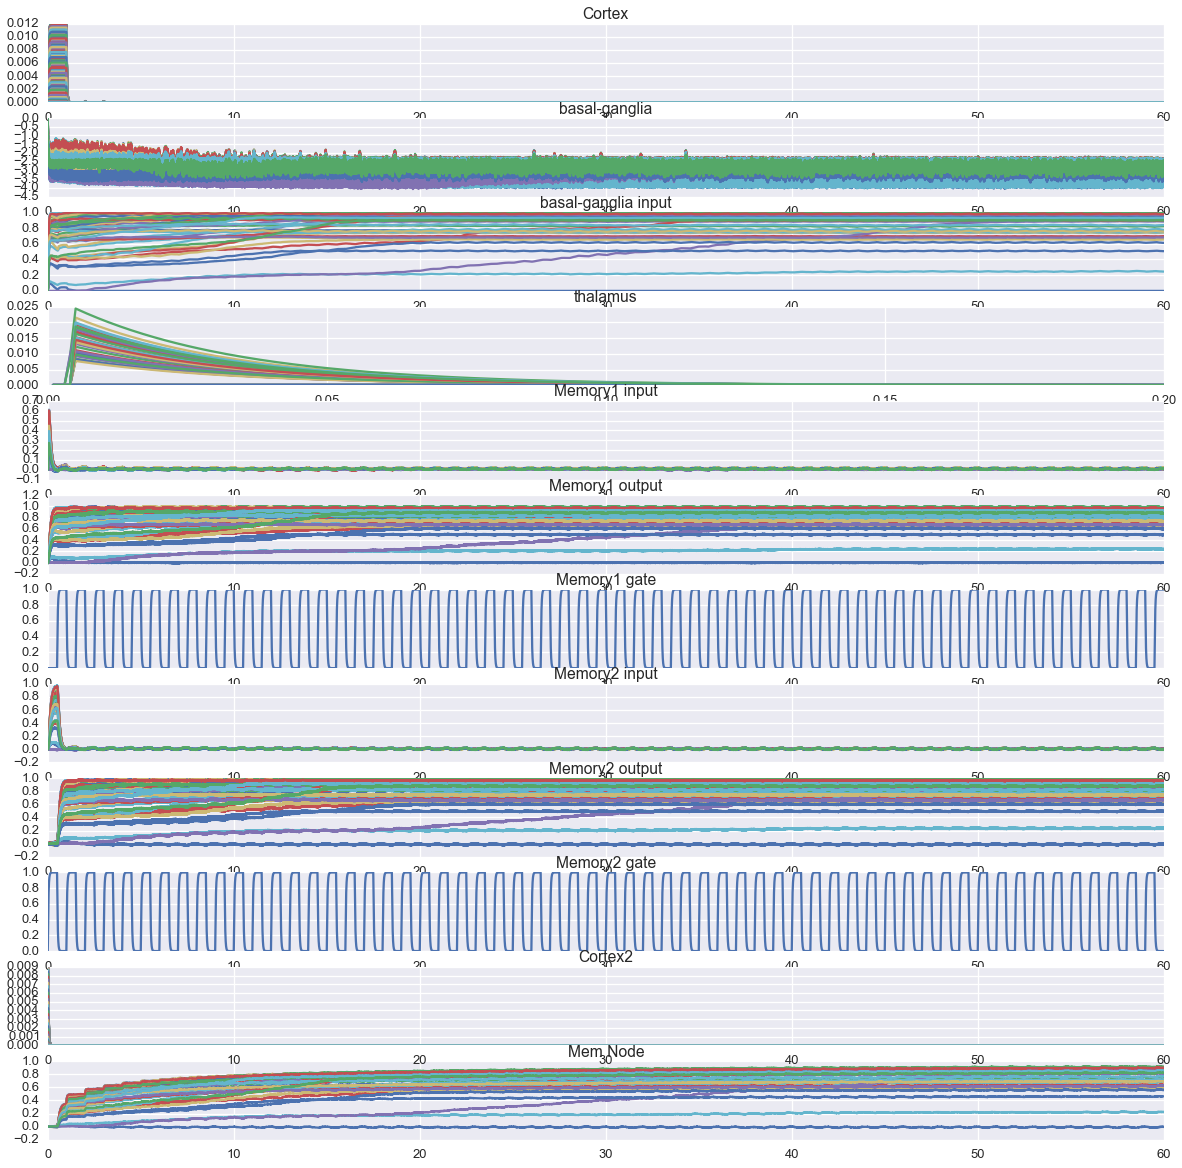

In [43]:
plt.figure(figsize=(20, 20))

plt.subplot(12, 1, 1)
plt.plot(sim.trange(), sim.data[cortex_p])
plt.title("Cortex")

plt.subplot(12, 1, 2)
plt.plot(sim.trange(), sim.data[bg_p])
plt.title("basal-ganglia")

plt.subplot(12, 1, 3)
plt.plot(sim.trange(), sim.data[bg_pin])
plt.title("basal-ganglia input")
#plt.ylim(-0.30, -0.28)

plt.subplot(12, 1, 4)
plt.plot(sim.trange(), sim.data[thal_p])
plt.title("thalamus")
plt.xlim(0,0.2)

#'''
plt.subplot(12, 1, 5)
plt.plot(sim.trange(), sim.data[memory1_ip])
plt.title("Memory1 input")

plt.subplot(12, 1, 6)
plt.plot(sim.trange(), sim.data[memory1_op])
plt.title("Memory1 output")

plt.subplot(12, 1, 7)
plt.plot(sim.trange(), sim.data[memory1_gp])
plt.title("Memory1 gate")


plt.subplot(12, 1, 8)
plt.plot(sim.trange(), sim.data[memory2_ip])
plt.title("Memory2 input")

plt.subplot(12, 1, 9)
plt.plot(sim.trange(), sim.data[memory2_op])
plt.title("Memory2 output")

plt.subplot(12, 1, 10)
plt.plot(sim.trange(), sim.data[memory2_gp])
plt.title("Memory2 gate")
#'''

#plt.subplot(12, 1, 11)
#plt.plot(sim.trange(), sim.data[node_ctxp])
#plt.title("Cortex Node")

plt.subplot(12, 1, 12)
plt.plot(sim.trange(), sim.data[node_memp])
plt.title("Mem Node");



plt.subplot(12, 1, 11)
plt.plot(sim.trange(), sim.data[cortex2_p])
plt.title("Cortex2")

'''
plt.subplot(12, 1, 12)
#plt.plot(sim.trange(), sim.data[test_p])
plt.title("test")
'''


In [ ]:
thal_output = sim.data[thal_p][100]
bg_output = sim.data[bg_p][-1]
winner_idx  =  np.argmax(thal_output)
print "Winner index: ", winner_idx
factor = thal_output[winner_idx]
print "thal real factor: ", factor

print "RMSE: ", rmse(sim.data[cortex2_p][-1], pZA[winner_idx, :])
print "RMSE (pred): ", rmse(sim.data[cortex2_p][-1], pZA[pred_index, :])
print "RMSE (pred): ", rmse(pZA[32, :], pZA[pred_index, :])

#print bg_output[winner_idx[0]]

plt.figure()
plt.plot(thetas, sim.data[cortex2_p][-1], 'r')
plt.plot(thetas, pZA[pred_index, :], 'k')
plt.plot(thetas, pZA[32, :], 'g')

plt.figure()
plt.plot(sim.trange(), sim.data[bg_pin])
plt.title("basal-ganglia input")
plt.ylim(-0.7, -0.3)

In [45]:
k = [-0.4, -0.1, -0.8]
y = [1+x for x in k]
print k
print y

[-0.4, -0.1, -0.8]
[0.6, 0.9, 0.19999999999999996]


In [51]:
#memory2_op
print np.argmin(sim.data[thal_p][100])

test =  thal_p #bg_pin #thal_p
print np.argmax(sim.data[test][0])
print np.argmax(sim.data[test][10])
print np.argmax(sim.data[test][20])
print np.argmax(sim.data[test][30])
print np.argmax(sim.data[test][100])
print np.argmax(sim.data[test][200])
print np.argmax(sim.data[test][300])
print np.argmax(sim.data[test][500])

print np.argmax(sim.data[test][1000])
print np.argmax(sim.data[test][2000])
print np.argmax(sim.data[test][5000])
print np.argmax(sim.data[test][7000])
print np.argmax(sim.data[test][19000])
print np.argmax(sim.data[test][20000])
print np.argmax(sim.data[test][30000])
print np.argmax(sim.data[test][40000])
print np.argmax(sim.data[test][50000])

print np.argmax(sim.data[test][-1])


'''
print np.argmax(sim.data[test][60000])
print np.argmax(sim.data[test][80000])
print np.argmax(sim.data[test][90000])
print np.argmax(sim.data[test][95000])
print np.argmax(sim.data[test][98000])
'''
print sim.data[test][-1]
#print sim.data[test][-1][147]
#print sim.data[test][-1]
"""
bg_pin
0
152
166
147
269
269
147
147
123
123 => -0.1626493026
bg_pin 147: -0.182897755378

thal_p and bg_p
0
147
147
147
147
147
147
147
147
147 => -0.260603593642
bg_p 123: -0.403568977641

"""


0
0
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
1
1
[  0.00000000e+000   7.41098469e-323   0.00000000e+000   0.00000000e+000
   7.41098469e-323   0.00000000e+000   0.00000000e+000   7.41098469e-323
   7.41098469e-323   7.41098469e-323   7.41098469e-323   7.41098469e-323
   7.41098469e-323   7.41098469e-323   7.41098469e-323   7.41098469e-323
   0.00000000e+000   7.41098469e-323   7.41098469e-323   0.00000000e+000
   7.41098469e-323   7.41098469e-323   7.41098469e-323   0.00000000e+000
   7.41098469e-323   7.41098469e-323   7.41098469e-323   7.41098469e-323
   7.41098469e-323   0.00000000e+000   0.00000000e+000   0.00000000e+000
   7.41098469e-323   7.41098469e-323   0.00000000e+000   7.41098469e-323
   0.00000000e+000   7.41098469e-323   7.41098469e-323   0.00000000e+000
   7.41098469e-323   7.41098469e-323   0.00000000e+000   7.41098469e-323
   7.41098469e-323   0.00000000e+000   0.00000000e+000   7.41098469e-323
   0.00000000e+000   7.41098469e-323]


'\nbg_pin\n0\n152\n166\n147\n269\n269\n147\n147\n123\n123 => -0.1626493026\nbg_pin 147: -0.182897755378\n\nthal_p and bg_p\n0\n147\n147\n147\n147\n147\n147\n147\n147\n147 => -0.260603593642\nbg_p 123: -0.403568977641\n\n'

##### Basal ganglia input sum

In [101]:
# bg-thal network works for both positive and negative values,
# it also works for a mix of positive and negative values,
# however its sensitive to the difference between the values
# for radius of 1, difference of 0.2 always gives accurate results
# for radius of 10, difference needs to be higher
model_bg = nengo.Network(label='test', seed=15)
dim = 4
model_bg.config[nengo.Ensemble].radius=10 #nengo.Direct() #nengo.LIFRate() 

with model_bg:
      
    def input(t):
        return [0.8, 0.5, 0.6, 0.2]
        if t%1 >0 and t%1 < 0.5:
            return [-0.2, -0.5, -0.6, -0.9]
        else:
            return [-0.8, -0.3, -0.1, -0.2]
            
    
    vec = [x*-1 for x in [-0.8, -0.4, -0.6, -0.2]]
    input_test = nengo.Node(output=vec, size_out=dim)


    # Creating the basal ganglia and the thalamus network
    BG = nengo.networks.BasalGanglia(dimensions=dim, net=model_bg, )  
    thal = nengo.networks.Thalamus(dimensions=dim, net=model_bg, )
    nengo.Connection(BG.output, thal.input, synapse=0.01)
    nengo.Connection(input_test, BG.input, synapse=0.01)
    
    
    bginput_p = nengo.Probe(BG.input, synapse=0.03)
    bgoutput_p = nengo.Probe(BG.output, synapse=0.03)
    thalout_p = nengo.Probe(thal.output, synapse=0.03)
    input_p = nengo.Probe(input_test, synapse=0.03)

    
sim = nengo.Simulator(model_bg)  # Create the simulator
sim.run(4.0) 

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:14.                                                 


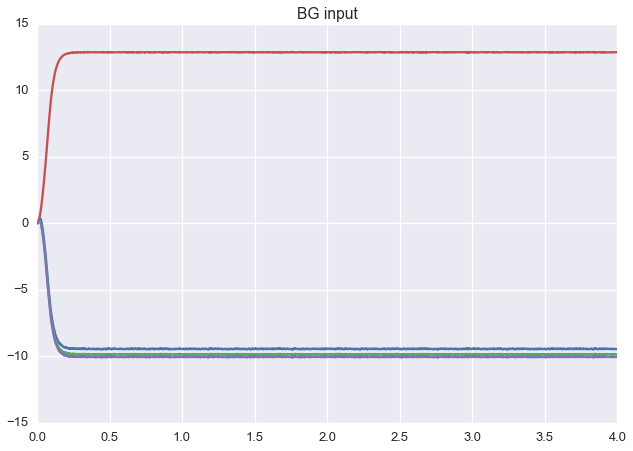

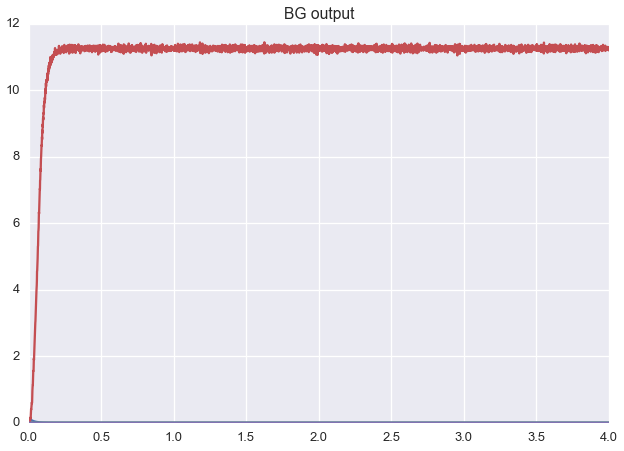

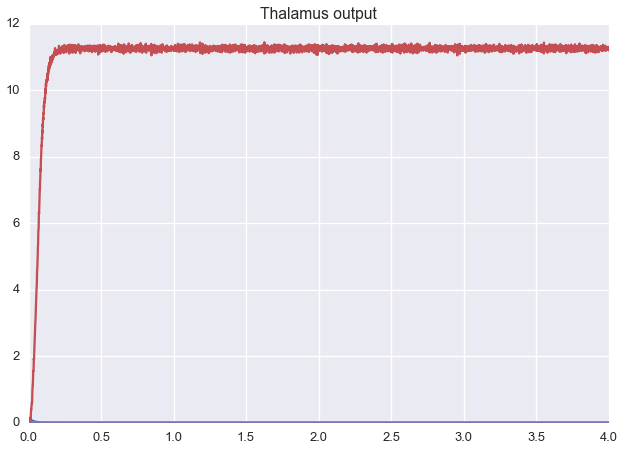

In [102]:
plt.figure()
plt.plot(sim.trange(), sim.data[bginput_p])
plt.title("BG input")

plt.figure()
plt.plot(sim.trange(), sim.data[bgoutput_p])
plt.title("BG output")

plt.figure()
plt.plot(sim.trange(), sim.data[thalout_p])
plt.title("Thalamus output")

In [104]:
test =  bginput_p  #, thalout_p

thal_output = sim.data[input_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[bginput_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[bgoutput_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[thalout_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx


[ 0.8  0.4  0.6  0.2]
Winner index:  0
[ -9.45111662  -9.85111662  12.85424104 -10.05111662]
Winner index:  2
[  1.82987164e-59   0.00000000e+00   1.12081783e+01   0.00000000e+00]
Winner index:  2
[  1.82987164e-59   0.00000000e+00   1.12081783e+01   0.00000000e+00]
Winner index:  2


##### Input gated memory

In [ ]:
## input gated memory
model_mem = nengo.Network(label='test', seed=15)
dim = M
with model_mem:
    
    def gate_mem(t):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "open the gate in first half, close in second"
        gate_input = 1
        comp = np.floor(t) if t>1 else 1
        if t%comp >= 0.5 and t%comp < 1:
            gate_input = 0
        elif t%comp >= 0 and t%comp < 0.5 and t!=0:
            gate_input = 1
        return gate_input

    
    gate = nengo.Node(output=gate_mem)
    input_test = nengo.Node(output=lambda t: 0.3 if t%1 > 0.5 else 0.6, size_out=1)
    memory = nengo.networks.InputGatedMemory(n_neurons=100, dimensions=1)

    nengo.Connection(gate, memory.gate)
    nengo.Connection(input_test, memory.input)
    
    mem_p = nengo.Probe(memory.output, synapse=0.03)
    mem_gp = nengo.Probe(memory.gate, synapse=0.03)
    input_p = nengo.Probe(input_test, synapse=0.03)

    
    
sim = nengo.Simulator(model_mem)  # Create the simulator
sim.run(6.0) 

In [ ]:
plt.figure()
plt.plot(sim.trange(), sim.data[input_p])
plt.title("Input gated memory")

plt.figure()
plt.plot(sim.trange(), sim.data[mem_p])
plt.title("Input gated memory")

plt.figure()
plt.plot(sim.trange(), sim.data[mem_gp])
plt.title("gated memory")

#### matrix operations

In [ ]:
## just showing here that Matrix (A.B)*n = A.(B*n)
A = np.ones((1,3))*5
B = np.ones((3, 5))
C = np.dot(A, B)
print C

A = np.ones((1,3))
B = np.ones((3, 5))
C = np.dot(A, B)
print C*5

##### Nengo model ends

In [ ]:
plt.figure()
plt.plot(np.arange(len(estimate_list)), 99*np.ones((len(estimate_list))), 'r')
plt.plot(np.arange(len(estimate_list)), estimate_list)
#plt.xlim(800200 - 800, 800200)
#plt.xlim(430000, 488000)
#plt.ylim(80, 120)
plt.xlabel("iteration no.", fontsize=25)
plt.ylabel("estimate", fontsize=25)

In [ ]:
# Plot the search space - priors we are searching over
plt.figure()
plt.title("Family of Priors (Search Space)")
for loc_value in alpha:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)
    

# Plot the priors with value of loc within +/-3 of 95
plt.figure()
plt.title("Priors found")    
loc_list = [loc-2, loc-1, loc, loc+1, loc+2]
for loc_value in loc_list:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)

In [ ]:
# raw empirical evaluation

# Compute the prior for all values of alpha
# this is our search space
#alpha = np.random.uniform(lower, upper+1, 10)    #loc or shift
#alpha2 = np.random.uniform(10, 40+1, 10)         #scale 
#alpha3 = np.random.uniform(-6, -6, 10)   #(-10, 5+1, 5)         #skew

# This setting gives rmse upto 0.006 which is too high
# reasonable performance if two parameters are fixed (rmse 0.002 - 0.004)
#alpha = np.random.uniform(89, 109, 10)    
#alpha2 = np.random.uniform(17, 37, 10)  
#alpha3 = np.random.uniform(-6, -6, 1) 

# This setting gives rmse upto 0.01 which is too bad
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-4, 4, 5)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.007 which is too high
# note that reducing the range of the scale really helped
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-4, -8, 5)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.004 which is not bad
# the problem is that I can't really keep the skew parameter 
# fixed ...lets try a small variation.
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.01 which is very bad
# so for skew, I can't have very far off options, otherwise
# it converges to them too. - BUT WHY???
# Lets check this for scale and shift too.
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(4, 8, 1)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.02 which is very bad
# converges on a distribution which is wayy far off. 
# seems like it might be because I am only using 5 values
# for each, so convergence path might not be straightforward.
# Increasing it from 5 to 10 now
#alpha = np.random.uniform(20, 50, 5)    #loc or shift
#alpha2 = np.random.uniform(7, 17, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# didn't work, again rmse 0.02
#alpha = np.random.uniform(20, 50, 10)    #loc or shift
#alpha2 = np.random.uniform(7, 17, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# here I changed the range of scale, as a results, the 
# resulting distributions don't have much overlap with 
# the optimal distribution. So convergest to the optimal
# always: both with 5 and 10 samples for scale and shift.

# Changing range of skew fto (4,8,1) agains brings back
# rmse to 0.06 due to much more overlap of distributions.
# even increasing the number of samples to 8000, results 
# stay the same. 
#alpha = np.random.uniform(20, 50, 5)    #loc or shift
#alpha2 = np.random.uniform(37, 57, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# rmse = 0.02 - terrible, converging to a distributions 
# with almost no overlap.
#alpha = np.random.uniform(0, 140, 10)    #loc or shift
#alpha2 = np.random.uniform(0, 47, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# rmse = between 0.002 and 0.003 - pretty good
# my conclusion is that maybe more steps are needed i.e 10 samples
#alpha = np.random.uniform(90, 105, 10)    #loc or shift
#alpha2 = np.random.uniform(20, 35, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 2)   #(-10, 5, 20)           #skew

# rmse = 0.001 pe aa gayee due to decreasing the number of
# samples from 10 to 5

# 15 samples  => rmse upto 0.02
# 10 samples  => rmse upto 0.03
# 5 samples  => rmse upto 0.03
# 25 samples => rmse upto 0.01 but also as low as 0.0007 in 3 out of 5 samples
# so definitely having more samples helps presumably to traverse the space.
#alpha = np.random.uniform(90, 105, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 35, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# in this case I have increased the range of parameters
# shift and scale. 
# rmse => 0.008, 0.002, 0.001, 0.01, 0.002
# so seems like increasing the samples helps even if the range is increased
#alpha = np.random.uniform(70, 115, 25)    #loc or shift
#alpha2 = np.random.uniform(10, 45, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# On Further expandig the range, rmse => upto 0.02 BAD
#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# Now I am just gonna find the optimal range that works
# provided all three parameters are varied
# okay for this combo, already rmse => 0.06
# which is pretty bad, but to be fair the predicted distribution
# shouldn't even be in the search space. So the next task is to find a 
# sensible range for each of these hyperparameters.
#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-5, -7, 2)   #(-10, 5, 20)           #skew

# rmse goes to 0.008 once in 5 times
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, 5, 2)   #(-10, 5, 20)           #skew

# this one is converging to the optimal sometimes
# rmse = 0 sometimes and sometimes goes upto 0.007
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)   

# ***mostly converging to the optimal except few outliers
# with rmse = 0.005 or 0.009
# alpha = np.random.uniform(21, 142, 25)    #loc or shift
# alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
# alpha3 = np.random.uniform(-8, -4, 1)   #(-10, 5, 20)   

# rmse back to 0.01 to 0.001
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-8, -4, 2)   #(-10, 5, 20)   

# rmse upto 0.007 (not enough samples though)
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale #
#alpha3 = np.random.uniform(-7, -5, 5)   #(-10, 5, 20)  

# rmse upto 0.01
#alpha = np.random.uniform(70, 122, 15)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 15)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-7, -5, 5)   #(-10, 5, 20) 

# ***rmse = 0.001 - 0.005 ; 0.005 much less frequently than 0.001
#alpha = np.random.uniform(70, 122, 15)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 15)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-8, -4, 5)   #(-10, 5, 20) 

# rmse is never going above 0.005 even with this combo
# increased range for the shift and scale but previous  
# one was better accuracy for sure.
alpha = np.random.uniform(21, 142, 15)    #loc or shift
alpha2 = np.random.uniform(20, 125, 15)   #(1, 126, 20)           #scale 
alpha3 = np.random.uniform(-8, -4, 5)   #(-10, 5, 20)